<a href="https://colab.research.google.com/github/plttraining/hsf_matplotlib_notebooks/blob/main/ep04_higgs_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this cell only if running on Google Colab
Else you can skip this cell below

In [ ]:
! git clone https://github.com/plttraining/hsf_matplotlib_notebooks.git
! cd hsf_matplotlib_notebooks/; pip install -r requirements.txt 
% cd hsf_matplotlib_notebooks/

# Introduction

#### In this episode, we will go through a first HEP analysis where you will be able to apply your knowledge of matplotlib and learn something new.

As we mentioned before the goal is to reveal the decay of the Standard Model Higgs boson to two Z bosons and subsequently to four leptons (H->ZZ->llll), this is called as a “golden channel”.

For this tutorial we will use the [ATLAS data](http://opendata.atlas.cern/samples-13tev/) collected during 2016 at a center-of-mass energy of 13 TeV, equivalent to 10fb⁻¹ of integrated luminosity.
Here we will use the available 4 leptons final state samples for simulated samples (Monte Carlo "MC") and data, that after a selection, we will reveal a narrow invariant mass peak at 125 GeV, the Higgs.

First we need to import numpy and the matplotlib.pyplot module under the name plt, as usual

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

<font color=yellow>Auto-show in jupyter notebooks:</font> The jupyter backends (activated via %matplotlib inline, %matplotlib notebook, or %matplotlib widget), call show() at the end of every cell by default. Thus, you usually don’t have to call it explicitly there. 

---

# Samples

In the following dictionary, we have classified the samples we will work on, starting with the “data” samples, followed by the “higgs” MC samples and at the end the “zz” and “others” MC background components.

In [2]:
samples_dic= {'data': [['data', 'data_A'], 
                       ['data', 'data_B'], 
                       ['data', 'data_C'], 
                       ['data', 'data_D']],
              'higgs': [['mc', 'mc_345060.ggH125_ZZ4lep'], 
                        ['mc', 'mc_344235.VBFH125_ZZ4lep']], 
              'zz': [['mc', 'mc_363490.llll']], 
              'other': [['mc', 'mc_361106.Zee'], 
                        ['mc', 'mc_361107.Zmumu']]}

We will use uproot to read the content of our samples that are in ROOT format.

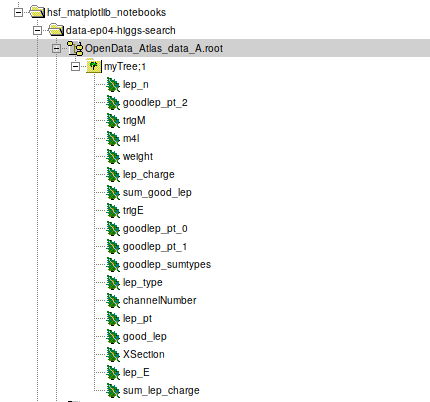

In [3]:
from IPython.display import Image
Image(filename='./data-ep04-higgs-search/tree_plot.png')

In [4]:
import uproot

<font color=yellow>Uproot tutorial:</font> If you want to learn more of the Uproot python Module you can take a look to the tutorial also given by the HEP software foundation in the following [link.](https://hsf-training.github.io/hsf-training-uproot-webpage/index.html)

For each sample of the above `samples_dic`, we will return another dictionary that will contain all the "branches" or "variables"". 

In [5]:
processes = samples_dic.keys()
Tuples={}
samples=[]
for p in processes:
    for d in samples_dic[p]:
        # Load the dataframes
        sample = d[1] # Sample name
        samples.append(sample)
        DataUproot = uproot.open(f'./data-ep04-higgs-search/OpenData_Atlas_{sample}.root')
        Tuples[sample] = DataUproot['myTree']

Let's take a look to the "branches" stored in out data samples, taking "data_A" as example

In [6]:
Tuples['data_A']

<TTree 'myTree' (18 branches) at 0x7f29d88fd670>

In [7]:
list(Tuples['data_A'].keys())

['lep_n',
 'goodlep_pt_2',
 'trigM',
 'm4l',
 'weight',
 'lep_charge',
 'sum_good_lep',
 'trigE',
 'goodlep_pt_0',
 'goodlep_pt_1',
 'goodlep_sumtypes',
 'lep_type',
 'channelNumber',
 'lep_pt',
 'good_lep',
 'XSection',
 'lep_E',
 'sum_lep_charge']

Let's access one of these "branches" and make a simple plot:

In [8]:
branches={}
for s in samples:
    branches[s] = Tuples[s].arrays()

Using the pyplot `hist` function we can visualize the distribution the mass of the 4 leptons "m4l" for example fot the "data_A" sample.

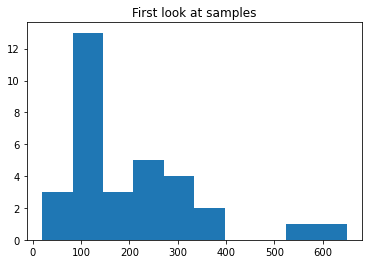

In [9]:
plt.title("First look at samples")
plt.hist(branches['data_A']['m4l'])
plt.show()

Tip: In the previous plot the numbers in the axis are very small, we can change the font size (and font family) for all the following plots, including in our code:

In [10]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20, 'font.family': 'serif'})#'sans-serif', 'monospace'

Note that this changes the global setting, but it can still be overwritten later.
<br>
Let's do the plot again to see the changes:

(array([ 3., 13.,  3.,  5.,  4.,  2.,  0.,  0.,  1.,  1.]),
 array([ 19.312525,  82.30848 , 145.30444 , 208.3004  , 271.29636 ,
        334.2923  , 397.28827 , 460.2842  , 523.28015 , 586.2761  ,
        649.2721  ], dtype=float32),
 <BarContainer object of 10 artists>)

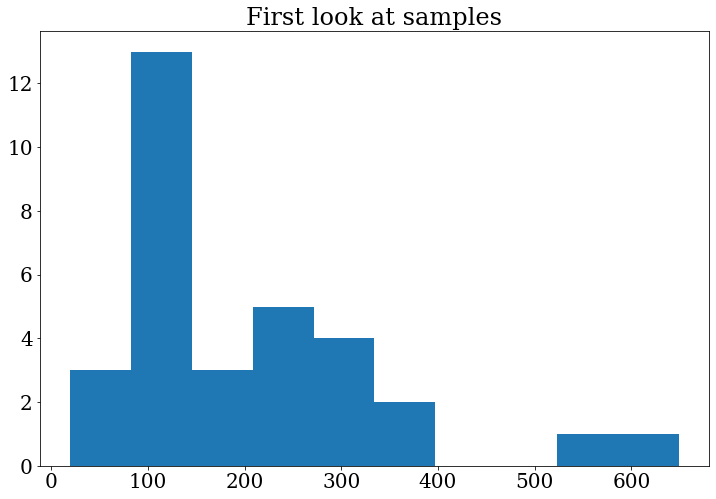

In [11]:
plt.figure(figsize=(12,8))
plt.title("First look at samples")
plt.hist(branches['data_A']['m4l'])

### Exercise

Make the histogram of the variable m4l for sample mc_363490.llll.

In the range [0,200].

With bins=50.

Include a legend “llll”.

Include the axis labels “Events” and “m4l”, in the axis y and x, respectively.

In [12]:
#Solution

---

# Selection criteria

Is very important to include some selection criteria in our samples MC and data that we are analyzing. These selections are commonly know as “cuts”. With these cuts we are able to select only events of our interest, this is, we will have a subset of our original samples and the distribution are going to change after this cuts. This will help out to do some physics analysis and start to search for the physics process in which we are interested. In this case is the 4 lepton final state.

To do this, we will select all events, from all the samples, that satisfy the following criteria:

    - the leptons need to activate either the muon or electron trigger,
    - number of leptons in the final state should be 4,
    - the total net charge should be zero,
    - the sum of the types (11:e, 13:mu) can be 44 (eeee), 52 (mumumumu) or 48 (eemumu),
    - good leptons with high transverse momentum

Let’s visualize some of these requirements. For now, let us continue working with the “data_A” sample. We can see how many good leptons we have in the event, by printing:

In [13]:
branches['data_A']['good_lep']

<Array [[1, 1, 1, 1], [1, ... 1], [1, 0, 1, 1]] type='32 * var * int32'>

In [14]:
branches['data_A']['sum_good_lep']

<Array [4, 4, 3, 4, 4, 4, ... 4, 4, 2, 2, 4, 3] type='32 * int32'>

In [15]:
branches['data_A']['sum_good_lep'] == 4

<Array [True, True, False, ... True, False] type='32 * bool'>

In [16]:
sum_leptons_test = branches['data_A']['sum_good_lep'] == 4

### Exercise

Make a histogram of the variable “sum_good_lep” for the sample “data_A” or another sample.

Try to represent in you histogram what are the events that we want to keep using lines, arrows or text in you plot.

In [17]:
#Solution

Finally, let’s save in a dictionary for all the samples the requirements mentioned above as follows:

In [18]:
selection_events={}
for s in samples:
    # trigger
    trigger = ((branches[s]['trigM'] == True) | (branches[s]['trigE'] == True))
    sum_leptons = branches[s]['sum_good_lep'] == 4
    sum_charge = branches[s]['sum_lep_charge'] == 0
    sum_types_ee = branches[s]['goodlep_sumtypes'] == 44
    sum_types_mm = branches[s]['goodlep_sumtypes'] == 52
    sum_types_em = branches[s]['goodlep_sumtypes'] == 48
    sum_types_goodlep = (sum_types_ee | sum_types_mm | sum_types_em)
    sum_lep_selection = (sum_leptons & sum_charge & sum_types_goodlep)
    # Select leptons with high transverse momentum
    pt_0_selection = branches[s]['goodlep_pt_0'] > 25000
    pt_1_selection = branches[s]['goodlep_pt_1'] > 15000
    pt_2_selection = branches[s]['goodlep_pt_2'] > 10000
    high_pt_selection = (pt_0_selection & pt_1_selection & pt_2_selection)
    final_selection = trigger & sum_types_goodlep & sum_lep_selection & high_pt_selection
    selection_events[s] = final_selection

Moreover, we can compare, by printing, the number of initial and final events after the previous selection .

In [19]:
for s in samples:
    print(s,'      Initial events: ', len(branches[s]['m4l']))

data_A       Initial events:  32
data_B       Initial events:  108
data_C       Initial events:  174
data_D       Initial events:  277
mc_345060.ggH125_ZZ4lep       Initial events:  163316
mc_344235.VBFH125_ZZ4lep       Initial events:  189542
mc_363490.llll       Initial events:  547603
mc_361106.Zee       Initial events:  244
mc_361107.Zmumu       Initial events:  148


In [20]:
for s in samples:
    final_len=len(branches[s]['m4l'][selection_events[s]])
    print(s,'      After selection: ',final_len, ' (', round(final_len*100/len(branches[s]['m4l']),2), '%)')

data_A       After selection:  18  ( 56.25 %)
data_B       After selection:  52  ( 48.15 %)
data_C       After selection:  93  ( 53.45 %)
data_D       After selection:  158  ( 57.04 %)
mc_345060.ggH125_ZZ4lep       After selection:  141567  ( 86.68 %)
mc_344235.VBFH125_ZZ4lep       After selection:  161106  ( 85.0 %)
mc_363490.llll       After selection:  454732  ( 83.04 %)
mc_361106.Zee       After selection:  27  ( 11.07 %)
mc_361107.Zmumu       After selection:  16  ( 10.81 %)


Notice that the background events are reduced meanwhile we try to keep most of the signal.

---

# MC samples

To make a plot with all the MC samples we will do a stack plot. We will merge the samples following the classification we introduced at the beginning, that is:

In [21]:
mc_samples=list(processes)[1:]
print(mc_samples)

['higgs', 'zz', 'other']


Remember that our variable of interest is the mass of the 4 leptons (m4l), then, let’s append in stack_mc_list_m4l the values of this variable for the 3 merged samples corresponding to the processes above.

On the other hand, a very important aspect of the MC samples is the weights, these weights include important information that modifies the MC samples to be more like real data, so we will save them in stack_weights_list. Notice that the weights should be of the same shape variable that we want to plot.

In [22]:
stack_mc_list_m4l = []
stack_weights_list = []
for s in mc_samples:
    list_sample_s = []
    list_weight_s = []
    for element in samples_dic[s]:
        sample_s=element[1]
        mc_selection_values = branches[sample_s]['m4l'][selection_events[sample_s]]
        list_sample_s += list(mc_selection_values)
        mc_selection_weight = branches[sample_s]['weight'][selection_events[sample_s]]
        list_weight_s += list(mc_selection_weight)
    stack_mc_list_m4l.append(list_sample_s)
    stack_weights_list.append(list_weight_s)

We can check the lengths, to see that everything is ok.

In [23]:
for k in range(0,3):
    print(len(stack_mc_list_m4l[k]), len(stack_weights_list[k]))

302673 302673
454732 454732
43 43


And then make a plot, actually, let’s make 2 plots, with matplotlib we can add sub-plots to the figure, then, we will be able to compare the MC distribution without and with weights.

In order to do this, we will use the `subplot` function. Notice that in this case, we are creating a figure and defining the axes of the figure directly, the syntax of the functions that we call for these axes change a bit with respect to the ones using only pyplot. 

In [24]:
var_name = 'm4l'
units = ' [GeV]'
rangos = [[80,170]]
bines = 24 

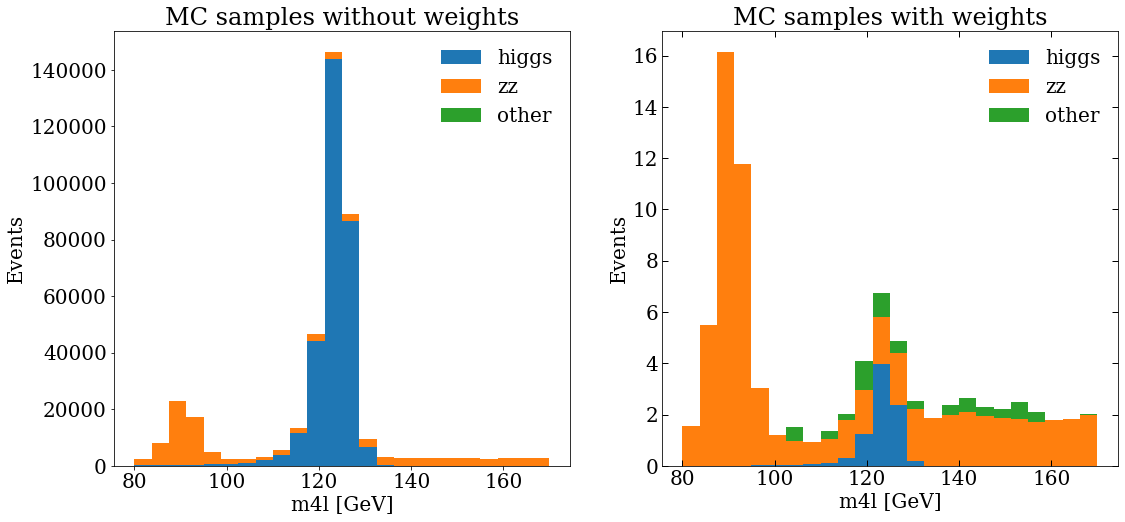

In [25]:
fig, (plot_1, plot_2) = plt.subplots(1,2, figsize=[18,8])
plot_1.set_title("MC samples without weights")
plot_1.hist(stack_mc_list_m4l, range=rangos[0], label=mc_samples, stacked=True, bins=bines)
plot_1.set_ylabel('Events')
plot_1.set_xlabel(var_name+units)
plot_1.legend(frameon=False)
plot_2.set_title("MC samples with weights")
plot_2.hist(stack_mc_list_m4l, range=rangos[0], label=mc_samples, stacked=True, weights=stack_weights_list, bins=bines)
plot_2.set_ylabel('Events')
plot_2.set_xlabel(var_name+units)
plot_2.tick_params(which='both',direction='in',top=True,right=True, length=6, width=1)
plot_2.legend(frameon=False)

---

# Data samples

Let’s append in stack_dara_list_m4l the values of the m4l variable for all the data samples A,B,C and D.

In [26]:
stack_data_list_m4l=[]
for element in samples_dic['data']:
    sample_d=element[1]
    #print(sample_d)
    data_list = list(branches[sample_d]['m4l'][selection_events[sample_d]])
    stack_data_list_m4l += data_list
    #print(sample_d,len(data_list))

We can print the length of the list to check again that everything is fine.

In [27]:
len(stack_data_list_m4l)

321

To make more easy the data vs. MC final plot, we can define the following helper function that makes a histogram of the data and calculates the poisson uncertainty in each bin.

When we want to make a plot that includes uncertainties we need to use the plt.errorbar function.

In [28]:
def plotData(data_var, range_ab, bins_samples):
    data_hist,bins = np.histogram(data_var, range=range_ab, bins=bins_samples) 
    print(data_hist, bins)
    data_hist_errors = np.sqrt( data_hist )
    bin_center=(bins[1:]+bins[:-1])/2
    h0=plt.errorbar(x=bin_center, y=data_hist, yerr=data_hist_errors,fmt='kv', label='Data')#, capsize=3,, ms=10)

---

# Data vs. MC plot

Finally, we can include the MC and data in the same figure, and see if they are in agreement :).

[ 1  6 20  7  4  3  1  0  2  1  7  9  7  3  3  1  4  1  2  4  2  1  4  2] [ 80.    83.75  87.5   91.25  95.    98.75 102.5  106.25 110.   113.75
 117.5  121.25 125.   128.75 132.5  136.25 140.   143.75 147.5  151.25
 155.   158.75 162.5  166.25 170.  ]


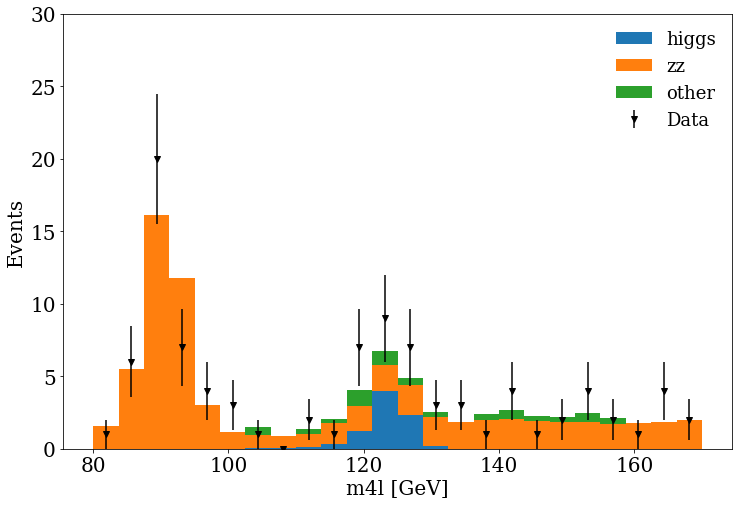

In [29]:
plt.figure(figsize=(12,8))
plotData(stack_data_list_m4l, rangos[0], bines)
h1=plt.hist(stack_mc_list_m4l, range=rangos[0], label=mc_samples, stacked=True, weights=stack_weights_list, bins=bines)
plt.ylabel('Events')
plt.xlabel(var_name+units)
plt.ylim(0,30)
plt.legend(fontsize=18,frameon=False)

### Exercise
Modify a bit the previous code to include the ticks and text, in the text and axis labels use latex to achieve the final plot.

In [30]:
#Solution

---

# Final Plot

### You can see at 125 GeV the component corresponding at the Higgs boson.

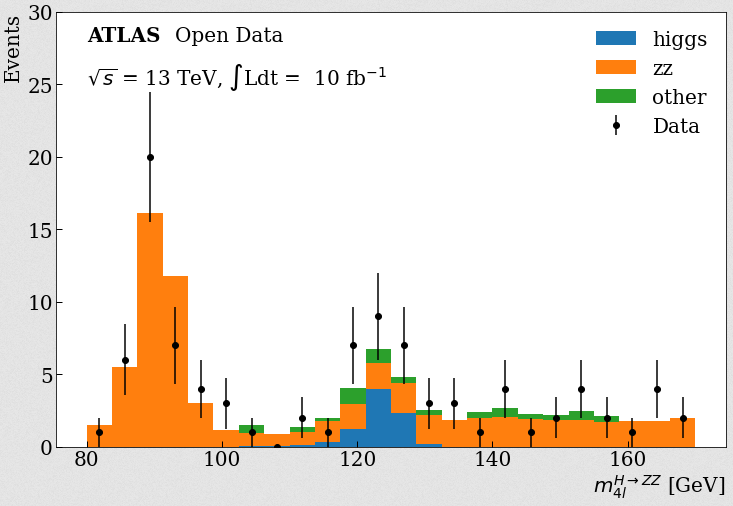

In [31]:
from IPython.display import Image
Image(filename='./data-ep04-higgs-search/Finalplot.png')

---

**Bonus**: If you are more curious about other HEP analysis tools, you can take a look at this same example developed with the ROOT framework [here](https://root.cern.ch/doc/v622/df106__HiggsToFourLeptons_8py.html).
